<a href="https://colab.research.google.com/github/DineshChopra/AI-ML/blob/master/TensorFlow/Udacity/6_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Hub and Transfer Learning

## Concepts that will be covered in this colab
1. Use a TensorFlow Hub model for prediction
2. Use a TensorFlow Hub model for Dogs vs. Cats dataset
3. Do simple transfer learning with TensorFlow Hub

In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Part 1: Use a TensorFlow Hub MobileNet for prediction

## Download the classifier

In [4]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
  hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Run it on a Single Image

65536/61306 [================================] - 0s 0us/step


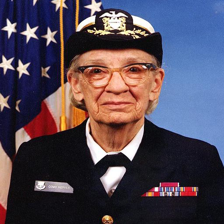

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper) / 255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

## Decode the prediction

16384/10484 [==============================================] - 0s 0us/step


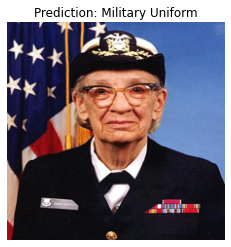

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

#Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

## Dataset

In [10]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteF9064E/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [11]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [13]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Run the classifier on a batch of images

In [14]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Eskimo dog', 'beagle', 'tabby', 'pug', 'golden retriever',
       'Great Pyrenees', 'Persian cat', 'Boston bull', 'Persian cat',
       'tabby', 'lynx', 'Irish water spaniel', 'Doberman', 'tabby',
       'Labrador retriever', 'Persian cat', 'Great Dane', 'Persian cat',
       'Egyptian cat', 'collie', 'Egyptian cat',
       'wire-haired fox terrier', 'tabby', 'Irish setter', 'Persian cat',
       'groenendael', 'Egyptian cat', 'miniature schnauzer', 'clumber',
       'Egyptian cat', 'lynx', 'Border terrier'], dtype='<U30')

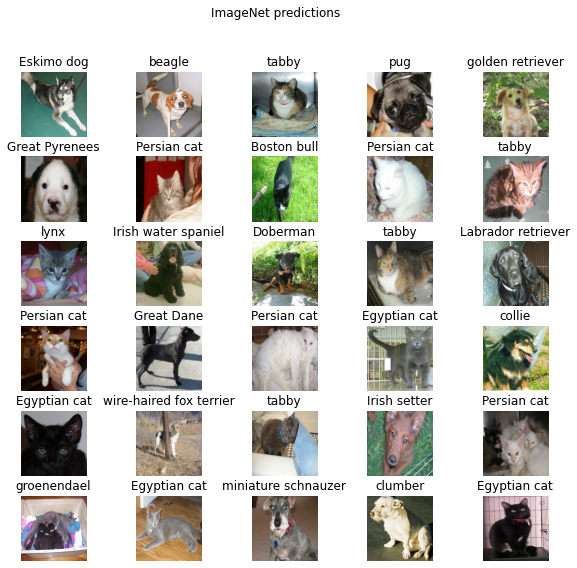

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Part 3: Do simple transfer learning with TensorFlow Hub